In [1]:
'''
sentiment file names for eng/ger
Merge labels and features depending on how labels are aggregated if there are multiple scores for a work.
drop_column reset index???
chunk based features?
complexity features
take out doc2vec_chunk_embedding from default drop columns
'''

'\nsentiment file names for eng/ger\nMerge labels and features depending on how labels are aggregated if there are multiple scores for a work.\ndrop_column reset index???\nchunk based features?\ncomplexity features\ntake out doc2vec_chunk_embedding from default drop columns\n'

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "/home/annina/scripts/great_unread_nlp/data/labels/"
lang = "eng"

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)

In [4]:
labels 
#len(pd.unique(labels["book_name"])) #197

# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts with opposing reviews

,book_name,y,c
0,Anonymous_Anonymous_The-Adventures-of-Anthony-...,0.000000,positive
1,Austen_Jane_Pride-and-Prejudice_1813,0.000000,positive
2,Austen_Jane_Sense-and-Sensibility_1811,0.000000,positive
3,Barrie_J-M_Auld-Licht-Idylls_1888,0.000000,positive
4,Barrie_J-M_Sentimental-Tommy_1896,0.000000,positive
...,...,...,...
249,Wells_H-G_Ann-Veronica_1909,-0.019978,not_classified
250,Wells_H-G_The-First-Men-in-the-Moon_1901,-0.040821,not_classified
251,Wells_H-G_The-Island-of-Dr-Moreau_1896,-0.044745,not_classified
252,Wilde_Oscar_The-Picture-of-Dorian-Gray_1890,0.007171,not_classified


<AxesSubplot:ylabel='Frequency'>

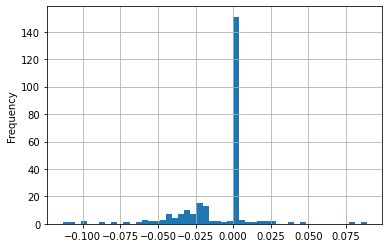

In [5]:
labels["y"].plot.hist(grid=True, bins=50)

In [6]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose
        self.datetime = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param):
        # if any of these performs better than others, we can try to tune the hyperparameters
        # but I think for now it"s more important to see which approach performs better
        # chunk based or doc based
        # use dimensionality reduction or not...
        if self.model == "xgboost": #1,0.25,2
            return XGBRegressor(n_estimators=1000, max_depth=model_param, learning_rate=0.01, colsample_bytree=0.33, min_child_weight=6) #max_depth=4
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        #Map author splits to book names
        book_splits = []
        for author_split in author_splits:
            book_split = []
            for author in author_split:
                book_split.extend(booknames_authors_mapping[author])
            book_splits.append(book_split)
        return book_splits
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        agg_labels = self.labels.groupby(by="book_name", as_index=False).mean()
        df = df.merge(right=agg_labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            model = self._get_model(self.model_param)
            model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            train_books["yhat"] = model.predict(train_X)
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + self.datetime + ".png", 
            dpi=400, bbox_inches="tight")    
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, self.datetime


In [7]:
'''
Classification into reviewed/not reviewed
'''

class Classification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        labels = labels.replace(to_replace={"positive": 3, "not_classified": 2, "negative": 1})
        labels = labels.drop_duplicates(subset="book_name")
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        agg_labels = self.labels[["book_name"]].drop_duplicates()
        agg_labels["y"] = 1
        df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after 1759 (year of first review)
        year = df["book_name"].str.split('_').str[-1].astype('int64')
        df = df.loc[year>=1759]
        return df
    
    def _get_sample_weights(self, df):
        # Weight 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        print(df)
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name") 
        
        # Majority vote
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index() 
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
        #Accuracy when each chunk is treated as single document
        chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
        
    def run(self):
        train_accs = []
        validation_accs = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            model = self._get_model(self.model_param)
            model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            train_books["yhat"] = model.predict(train_X)
            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            validation_books["yhat"] = model.predict(validation_X)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
            if self.verbose:
                print(f"Fold: {index+1}, TrainAcc: {np.round(train_acc, 3)}, ValAcc: {np.round(validation_acc, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))
                
        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)
        
        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
        print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)
        
        if self.verbose:
            print(f"""TrainAcc: {np.round(mean_train_acc, 3)}, ValidationAcc: {np.round(mean_validation_acc, 3)}""")
            print("\n---------------------------------------------------\n")
        return None

In [8]:
''' 
Classification into in library/not in library
'''

class LibraryClassification(Classification):
    def _prepare_labels(self):
        return self.labels

In [9]:
'''
Classification into not reviewed/negative/not classified/positive
'''

class MulticlassClassification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        labels = labels.replace(to_replace={"positive": 3, "not_classified": 2, "negative": 1})
        
        #Correct labels if book has opposed labels
        single_review = labels.groupby("book_name").filter(lambda x: len(x)==1) # 161 single review, 93 several
        multiple_reviews = labels.groupby("book_name").filter(lambda x: len(x)>1 and not(1 in x.values and 3 in x.values))
        #opposed_reviews = labels.groupby("book_name").filter(lambda x: len(x)>1 and (1 in x.values and 3 in x.values))
              
        def _correct_opposed_labels(group):
            count = group["y"].value_counts().reset_index().rename(columns={'index': 'y', "y": "count"})
            #take label with the highest count, take more extreme label if counts are equal
            if count.shape[0]>1:
                if count.iloc[0,1] == count.iloc[1,1]:
                    grouplabel = count["y"].max()
                else:
                    grouplabel = count.iloc[0,0]
                group["y"] = grouplabel
            return group
        multiple_reviews = multiple_reviews.groupby("book_name").apply(_correct_opposed_labels)
        multiple_reviews = multiple_reviews.drop_duplicates(subset="book_name")
        labels = pd.concat([single_review, multiple_reviews])
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
        print('labels value count', df["y"].value_counts())
        df["y"] = df["y"].fillna(value=0)#(value="not_reviewed")
        print('labels value count', df["y"].value_counts())
        #Select books written after 1759 (year of first review)
        year = df["book_name"].str.split('_').str[-1].astype('int64')
        df = df.loc[year>=1759]
        print('labels value count', df["y"].value_counts())
        return df
    
    def _get_sample_weights(self, df):
        # Weight 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name") 
        
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index() 
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: f1_score(group["y"], group["yhat"], average='macro')).mean()
        # Accuracy when each chunk is treated as single document
        # Chunk accuracy with sample weights returns book accuracy
        # Chunk accuracy is the only choice for bookl-level features
        chunk_acc = f1_score(df["y"], df["yhat"], average='macro')#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
        
    def run(self):
        train_accs = []
        validation_accs = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            model = SVC(C=self.model_param, class_weight='balanced')
            model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            train_books["yhat"] = model.predict(train_X)
            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            validation_books["yhat"] = model.predict(validation_X)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
            if self.verbose:
                print(f"Fold: {index+1}, TrainAcc: {np.round(train_acc, 3)}, ValAcc: {np.round(validation_acc, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + self.datetime + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))
        
        
        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)
        
        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print(mean_train_chunk_acc)
        print(mean_validation_chunk_acc)
        
        if self.verbose:
            print(f"""TrainAcc: {np.round(mean_train_acc, 3)}, ValidationAcc: {np.round(mean_validation_acc, 3)}""")
            print("\n---------------------------------------------------\n")
        return None

In [10]:
# Drop some columns by default before running cv
def drop_default_columns(df, drop_default_columns_including):
    def _drop_column(column):
        for string in drop_default_columns_including:
            if string in column:
                return True
    df = df[[column for column in df.columns if not _drop_column(column)]].reset_index(drop=True)
    return df

### Cross-validation

# Feature split
complexity_features = []


# Superfluous featues
drop_default_columns_including = ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"]

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [1, 4], "svc": [1]}
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', None]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
full_cv_params = {"model": models, "dimensionality_reduction": dimensionality_reduction, "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[3], 
                  "features": features[2]}
# Old results from chr2021 paper
eng_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
                  "features": features[2], }, # svr, pca, book_and_average_chunk
ger_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
                  "features": features[1]}, # svr, pca, chunk

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [11]:
results = []
param_dict = "testing" #"full_cv", "language_specific"
for lang in ["eng"]: #, "ger"]:    
    if param_dict=="testing":
        param_dir = testing_params
    elif param_dict=="full_cv":
        param_dir = full_cv_params
    elif param_dict=="language_specific":
        if lang=="eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    #book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
    #book_df = drop_default_columns(book_df, drop_default_columns_including)
    book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
    #chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
    chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)
    
    for model in [] + [param_dir['model']]:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in [param_dir["dimensionality_reduction"]]:
                for features in [param_dir["features"]]:
                    for drop_columns_including in [[]]:
                        if model == "svc":
                            experiment = MulticlassClassification(
                                language=lang,
                                features=features,
                                drop_columns_including=drop_columns_including,
                                dimensionality_reduction=dimensionality_reduction,
                                model_param=model_param,
                                model=model,
                                verbose=False
                            )
                            print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                            classification_results = experiment.run()
                            #results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_acc, mean_validation_acc))
                            
                            ########################################
                            #Library
#                             experiment = LibraryClassification(
#                                 language=lang,
#                                 features=features,
#                                 drop_columns_including=drop_columns_including,
#                                 dimensionality_reduction=dimensionality_reduction,
#                                 model_param=model_param,
#                                 model=model,
#                                 verbose=False
#                             )
                            #################################################
                            
                        else:
                            #try:
                            experiment = Regression(
                                language=lang,
                                features=features,
                                drop_columns_including=drop_columns_including,
                                dimensionality_reduction=dimensionality_reduction,
                                model_param=model_param,
                                model=model,
                                verbose=True
                            )
                            print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                            mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, datetime = experiment.run()
                            results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))

                            #except Exception as e:
    #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
    #                             print(e)

eng svc book_and_averaged_chunk [] None param= 1
labels value count 3.0    113
2.0     63
1.0     15
Name: y, dtype: int64
labels value count 0.0    415
3.0    113
2.0     63
1.0     15
Name: y, dtype: int64
labels value count 0.0    378
3.0    113
2.0     63
1.0     15
Name: y, dtype: int64
[[ 64 110 145  59]
 [  2   2  10   1]
 [  5  14  33  11]
 [  7  34  57  15]]
Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0         64  110  145   59  378
1.0          2    2   10    1   15
2.0          5   14   33   11   63
3.0          7   34   57   15  113
All         78  160  245   86  569
0.16720797799473958
0.14239139906010884


In [12]:
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
#             "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
#             "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
#             "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + param_dict + datetime + ".csv", index=False)